In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from histogram_filters import convolve
from kalman import plot_gaussian
from kalman import plot_kalman_process

# Kalman filter


- Continuous Gaussian linear Markov filter
- Parametric filter with parameters: $\mu$, $\sigma^2$
- Unimodal
- Google uses it to locate other cars

# The model (Moving object)
## Definition

$S_{k+1} = aS_{k} + U_k + W$

$X_k = S_k + V$

Similar to the [additive noise histogram filter](https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/Additive%20noise%20Histogram%20Filters.ipynb)  but with some fundamental differences:
- $S_k$ is a continuous process. No more discrete states
- $W_n$ is Gaussian
- $V$ is Gaussian

## Notation change

$X_{k+1} = aX_k + b_kU_k + W_k$

$Z_k = hX_k + V_k$

**$X$**: The state. In our example, the robot position

**$Z$**: The observation. 

**$W$**: The process noise. For the walking robot, high variance of $W$ means that the robot walking is not accurate.

**$a$**: The state transition factor. In our example, it is 1. If it is higher than one, this means it will be exponentially accelerating. Will make more sense with the Kalman Vector filter on the next section.

**$b_k$, $U_k$**: The control input model. Will make more sense with the Kalman Vector filter on the next section. For our walking robot, it will be one.

**$h$**: Observation model. Maps the true state space into the observation space

**$V_k$**: Observation Noise

# Generative model

In [192]:
def generate_sample(X_o = 0, sigma_w = 0.1,sigma_v = 0.1, h = 1, a = 1, b = 1, U = 1, steps = 10):
    measurements = [h*X_o + np.random.normal(0,sigma_v)]
    X_k = X_o
    for i in range(steps):
        X_k = a*X_k + b*U + np.random.normal(0,sigma_w)
        Z = h*X_k + np.random.normal(0,sigma_v)
        measurements.append(Z)
    return measurements

## Process noise >> Measurement noise
Lots of error to do the walking

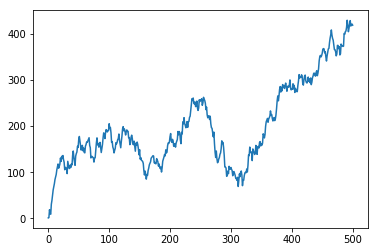

In [212]:
X_o = 0
P_0 = 100
U = 1
sigma_w = 10
sigma_v = 1
steps = 500
measurements = generate_sample(X_o = X_o, sigma_w = sigma_w,sigma_v = sigma_v, h = 1, a = 1, b = 1, U = U, steps = steps)
plt.plot(measurements)
plt.show()

## Measurement noise >> Process noise
Error observing but walking smoothly

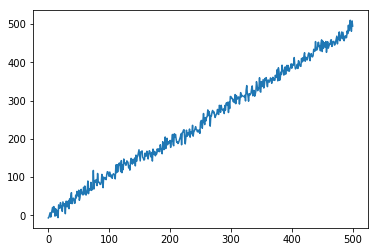

In [213]:
sigma_w = 1
sigma_v = 10
measurements = generate_sample(X_o = X_o, sigma_w = sigma_w,sigma_v = sigma_v, h = 1, a = 1, b = 1, U = U, steps = steps)
plt.plot(measurements)
plt.show()

# The model

Instead of having probabilities, we have densities. We use lowercase p is density, uppercase P for probability

**Process noise** (W) - Moving noise in our example:

$p(W) = N(0,\sigma_w^2) = \Large{\frac{1}{\sigma_w \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(W)}{\sigma_w^2}^2}}$

$\mu_w = 0$

**Observation noise / Measurement error**:

$p(V) = N(0,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(V)}{\sigma_v^2}^2}}$

$\mu_v = 0$

## The observation density - $Z_k = h X_k + V$
This is the density before observing given than we are on a specific state

V is Gaussian with mean 0, so $Z_k$ given we are in state $X_k$ will be Gaussian with mean of $h X_k$. 

$p(Z_k|X_k) = N(h X_k,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(Z_k-h X_k)}{\sigma_v^2}^2}}$


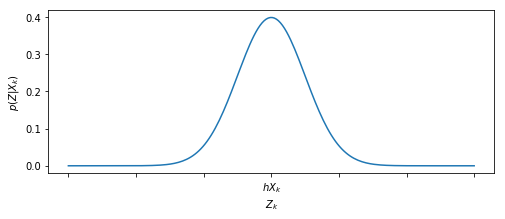

In [4]:
_ =plot_gaussian(N = 6, y_label = "$p(Z|X_k)$", x_label = "$Z_k$", center_label_tick = "$hX_k$",figsize=(8,3))

## The likelihood -  $\mathcal{L}(X_k|Z_k)$ = $p(Z_k|X_k)$ 

Remember that for the likelihood, the observation $Z$ is fixed and $X_k$ varies

$p(Z=Z_k|X_k) = N(h X_k,\sigma_v^2) = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(Z_k-h X_k)}{\sigma_v^2}^2}}
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(h\frac{Z_k}{h}-h X_k)}{\sigma_v^2}^2}} = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(\frac{Z_k}{h}-X_k)}{\frac{\sigma_v^2}{h^2}}^2}} =
\alpha N(\frac{Z_k}{h},\frac{\sigma_v^2}{h^2})$

This is equivalent to a Gaussian pdf that depends on $X_k$ with mean $\frac{Z}{h}$ and variance $\frac{\sigma_v^2}{h^2}$

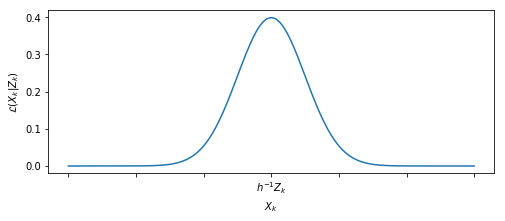

In [12]:
_ =plot_gaussian(N = 6, y_label = "$\mathcal{L}(X_k|Z_k)$", x_label = "$X_k$", center_label_tick = "$h^{-1}Z_k$",figsize=(8,3))

## Prior (belief): my belief before measuring

$p(X_k) = N(\hat{x}_{k}, p_{k}) = \Large{\frac{1}{\sqrt{2\pi p_{k}}} e^{-\frac{1}{2}\frac{(X_k-\hat{x}_{k})}{p_{k}}^2}}$

When starting, $p_{0}$ is the initial uncertainty. Usually larger than $\sigma_w^2$ and $\sigma_v^2$ and
$\hat{x}_{0}$ is the initial guess. Sometimes zero

## Posterior: probability of a state given the measurements


$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

**Bayes**:

$\large{p(X_k|Z_k) = \frac{p(Z_k|X_k)p(X_K)}{p(Z_k)}}$

$p(Z_k) = \int_{-\infty}^{\infty} {p(Z_k|X = x)p(x)} dx$

Because likelihood and prior are Gaussians, the posterior is Gaussian

# The filter
## The goal. Where am I?
Find my position $X_k$ given the observations
## Update - Bayes
Given the prior and the likelihood, find the posterior $X_k$

$Z_k = h X_k + V$

## Predict - Sum of random variable

$X_{k+1} = aX_{k} + bU_k + W$

## Loop
My prediction is my prior, so observe X again and update, and so on ...

# Properties of the gaussians - Parametric model

https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/pdfs/gaussians_convolutions_lecture3.pdf

## Update - Product of Gaussians pdfs

The product of 2 Gaussians pdfs with parameters $\mu_u$, $\sigma_u^2$ and $\mu_{v}$,$\sigma_{v}^2$ is proportional to a Gaussian with parameters $\mu_{x}$,$\sigma_{x}^2$ calculated as follows

$p(X) = \alpha p(U)p(V)$

$\mu_{x} = \Large{\frac{\sigma_u^2\mu_v +\mu_u \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$

Parallel resistances analogy

$\sigma_{x}^2 = \Large{\frac{\sigma_u^2 \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$


### Implementation

In [14]:
def gauss_pdf_mult(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return [new_mean, new_var]

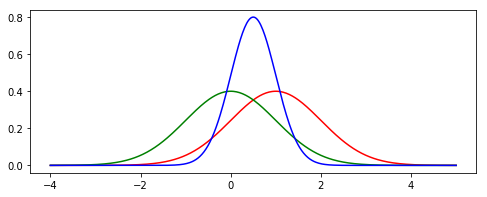

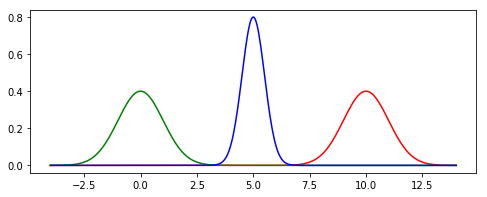

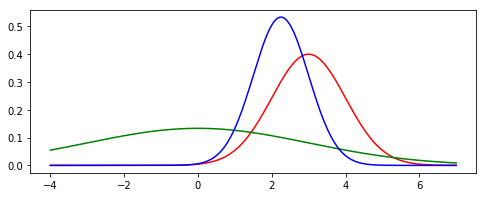

In [17]:
def plot_product(mu_u, sig_u, mu_v, sig_v, points=400):
    f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
    N = 4
    x = np.linspace(min(mu_u,mu_v)-N*sig_u, max(mu_u,mu_v)+N*sig_u, points)
    
    _, prior =plot_gaussian(mu = mu_u, sig = sig_u, N = 6, ax = ax, x=x, color = 'r')
    _, likelihood =plot_gaussian(mu = mu_v, sig = sig_v, ax = ax, x=x, color = 'g')

    mu_y, sig_y = gauss_pdf_mult(mu_u, sig_u, mu_v, sig_v)

    _ = plot_gaussian(mu = mu_y, sig = sig_y, N = 6, ax = ax, x=x, color = 'b')
    plt.show()
    
sig_u = 1; sig_v = 1; mu_u = 1; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 1; mu_u = 10; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 3; mu_u = 3; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)

### Conclusions
- The variance of the product of 2 pdfs is always less than the minimum of both.
- The product of 2 pdfs is not the same as the product of 2 random variables
- The update always lowers the uncertainty

### Applied to the model

$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

$\large{N(\hat{X}_{k|k}, p_{k|k})  = \alpha N(h^{-1}Z,\sigma_v^2h^{-2})N(\hat{X}_{k|k-1}, p_{k|k-1})}$


$ \sigma_x^2 = ({\sigma_a^2}^{-1} + {\sigma_b^2}^{-1})^{-1}$

$ \mu_x = \frac{\sigma_x^2 }{{\sigma_a^2}}\mu_a + \frac{\sigma_x^2}{{\sigma_b^2}}\mu_b = 
\sigma_x^2[\frac{\mu_a }{{\sigma_a^2}} + \frac{\mu_b}{{\sigma_b^2}}] $

$\sigma_x^2 = p_{k|k} \quad \sigma_a^2 = \frac{\sigma_v^2}{h^2} \quad \sigma_b^2 = p_{k|k-1}\quad$

$\mu_x = \hat{X}_{k|k} \quad \mu_a = h^{-1}Z \quad \mu_b = \hat{X}_{k|k-1}$

$p_{k|k} = \Large{\frac{p_{k|k-1} \sigma_v^2}{p_{k|k-1}h^{2} + \sigma_v^2}}$

$\hat{X}_{k|k} = p_{k|k}[\frac{hZ}{\sigma_v^2} +  \frac{\hat{X}_{k|k-1}}{p_{k|k-1}}]$

In [34]:
def update(h, sigma_v, Z, X_est_prior ,P_prior):
    P = P_prior*sigma_v/(P_prior*(h**2) + sigma_v)
    X_est = P*(h*Z/sigma_v + X_est_prior/P_prior)
    return X_est, P

## Predict - Convolution of Gaussians

The sum of random variables is equal to a Gaussian where the mean and the variances are the sum of the mean and variances respectively

$X = U + V$

$\mu_{X} = \mu_{U} +\mu_V$

$\sigma_{X}^2 = \sigma_{U}^2 +\sigma_V^2$

### Implementation

In [25]:
def gauss_var_add(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

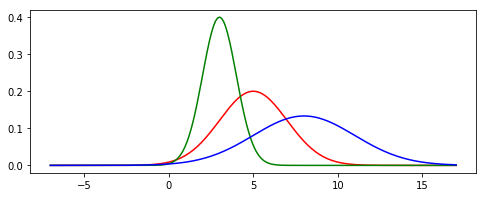

In [29]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
mu_s = 5
sig_s = 2
mu_w = 3
sig_w = 1
x, posterior = plot_gaussian(mu = mu_s, sig = sig_s, N = 6, ax = ax, color = 'r')
W = plot_gaussian(mu = mu_w, sig = sig_w, N = 6, ax = ax, x=x, color = 'g')

mu_p, sig_p = predict(mu_s,sig_s, mu_w,sig_w)

W = plot_gaussian(mu = mu_p, sig = sig_p, N = 6, ax = ax, x=x, color = 'b')
plt.show()

### Applied to the model:


$X_{k+1|k} = aX_{k|k} + bU_{k} + W$

$\mu_W = 0$

$\hat{X}_{k+1|k} = a\hat{X}_{k|k} +\mu_w + bU_k = a\hat{X}_{k|k} + bU_k$

$p_{k+1|k} = a^2p_{k|k} +\sigma_w^2$

$k = k + 1$

$\hat{X}_{k|k-1}$

$p_{k|k-1}$

Now update

In [57]:
def predict(sigma_w, X_updated, P_updated, a = 1, b = 1, U = 1):
    X_predicted = a*X_updated + b*U
    P_predicted = (a**2)*sigma_w + P_updated
    return X_predicted, P_predicted

# Our walking robot example
$X_{k+1} = X_k + 1 + W_k$

$Z_k = X_k + V_k$

## How the pdfs shrink through the process

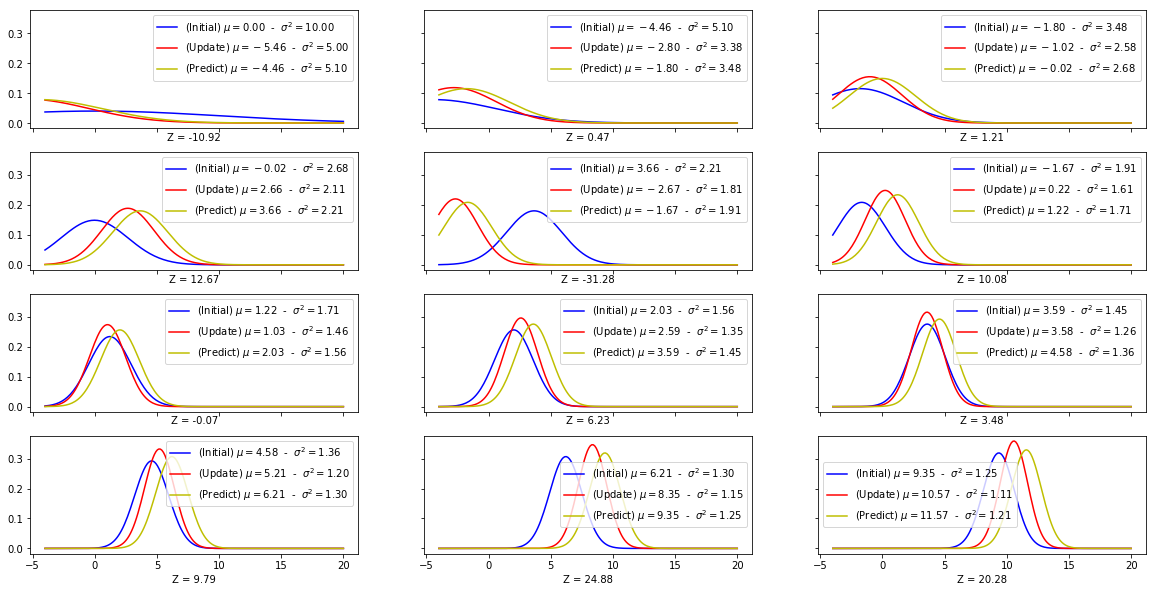

In [222]:
first = 5
last = 16
measurements = list(np.linspace(first,last,last-first+1))

# Variance of measurement
sigma_v = 10.
# Variance of action
sigma_w = 0.1
# Initial mu
X_o = 0.
# Initial variance
P_0 = 10.
points = 200
measurements = generate_sample(X_o = X_o, sigma_w = sigma_w,sigma_v = sigma_v, steps = 11)
plot_kalman_process(measurements, X_o, P_0, sigma_v, sigma_w, points = points, h = 1, a = 1, b = 1, U = 1)

## How the variance reduces

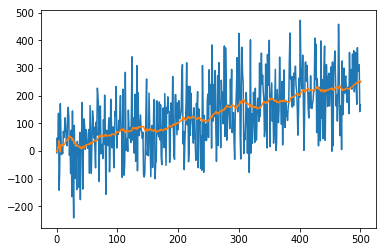

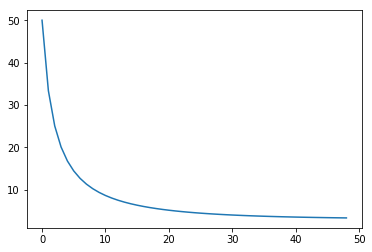

3.3744299638364161

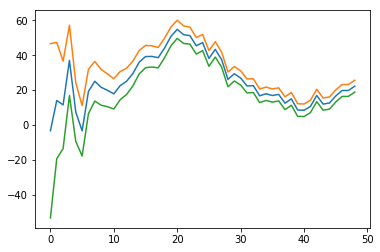

In [189]:
X_o = 0
P_0 = 100
U = 0.5
sigma_w = 0.1
sigma_v = 100
steps = 500
measurements = generate_sample(X_o = X_o, sigma_w = sigma_w,sigma_v = sigma_v, h = 1, a = 1, b = 1, U = U, steps = steps)

updated_means, update_variances = kalman_filter(measurements, X_o, P_0, sigma_v, sigma_w, h = 1, a = 1, b = 1, U = U)

update_stds = (np.array(update_variances))

mean_plus_var = np.array(updated_means) + update_stds
mean_minus_var = np.array(updated_means) - update_stds
zooming = 50

plt.plot(measurements)
plt.plot(updated_means)
plt.show()

plt.plot(np.array(update_stds)[1:zooming])
plt.show()
plt.plot(updated_means[1:zooming])
plt.plot(mean_plus_var[1:zooming])

plt.plot(mean_minus_var[1:zooming])
np.array(update_variances)[zooming]

## Observe once every N steps

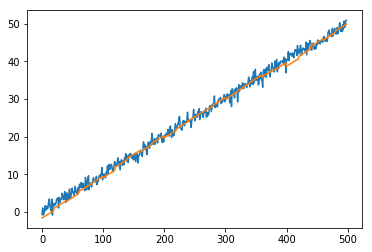

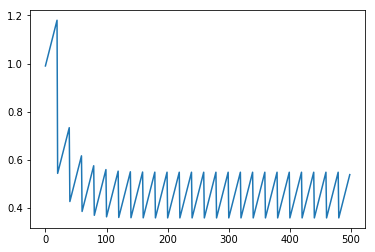

0.54825756970751449

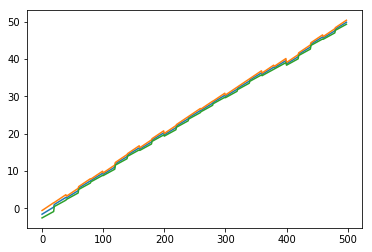

In [188]:
X_o = 0
P_0 = 100
U = 0.1
sigma_w = 0.01
sigma_v = 1
steps = 10000
measurements = generate_sample(X_o = X_o, sigma_w = sigma_w,sigma_v = sigma_v, h = 1, a = 1, b = 1, U = U, steps = steps)

updated_means, update_variances = kalman_filter(measurements, X_o, P_0, sigma_v, sigma_w, \
                                                h = 1, a = 1, b = 1, U = U, predict_ratio = 20)

update_stds = (np.array(update_variances))

mean_plus_var = np.array(updated_means) + update_stds
mean_minus_var = np.array(updated_means) - update_stds
zooming = 500

plt.plot(measurements[1:zooming])
plt.plot(updated_means[1:zooming])
plt.show()

plt.plot(np.array(update_stds)[1:zooming])
plt.show()
plt.plot(updated_means[1:zooming])
plt.plot(mean_plus_var[1:zooming])

plt.plot(mean_minus_var[1:zooming])
np.array(update_variances)[zooming]

# Updating and predicting in one step

$\mu_w = 0$

$\mu_{s_{k}} = \Large{\frac{\sigma_{v}^2\mu_{s_k} +\mu_{X_k} \sigma_{s_k}^2}{\sigma_{v}^2 + \sigma_{s_k}^2}}$

$\sigma_{s_{k}}^2 = \Large{\frac{\sigma_{s_{k}}^2 \sigma_v^2}{\sigma_{s_{k}}^2 + \sigma_v^2}}$

$\mu_{s_{k+1}} = a\mu_{s_k} + U_k$

$\sigma_{s_{k+1}}^2 = a^2\sigma_{s_k}^2 +\sigma_w^2$

Replacing

$\mu_{s_{k+1}} = \large{a\frac{\sigma_{v}^2\mu_{s_k} +\mu_{X_k} \sigma_{s_k}^2}{\sigma_{v}^2 + \sigma_{s_k}^2}} + U_k$

$\sigma_{s_{k+1}}^2 = a^2\large{\frac{\sigma_{s_{k}}^2 \sigma_v^2}{\sigma_{s_{k}}^2 + \sigma_v^2}} +\sigma_w^2$

$K_k = \large{\frac{\sigma_{S_k}^2}{\sigma_{S_k}^2 + \sigma_{v}^2}}$

$1 - K_k = \large{\frac{\sigma_{v}^2}{\sigma_{S_k}^2 + \sigma_{v}^2}}$

$\sigma_{s_{k+1}}^2 = a^2[1 - K]\sigma_{s_k}^2 +\sigma_w^2$

# Traditional equations

$S_n = a_nS_{n-1} + bU_n + W$

$X_n = S_n + V$

$P_1$ = $\sigma_s^2$ prior


$\hat{S_1}$ = $\mu_s$ prior

$K_n = \frac{P_n}{P_n+\sigma_v^2}$

$\hat{S_{n+1}} = a_{n+1}[\hat{S_n} + K_k(X_n - \hat{S_n})] + bU_n$

$P_{n+1} = a^2_{n+1}[1-K_n]P_n + \sigma_w^2$

$n = n + 1$

## How do the two models relate?

$K_n = \frac{P_n}{P_n+\sigma_v^2}$

$P_{n+1} = a^2_{n+1}[1-K_n]P_n + \sigma_w^2$

Replacing the first ecuacion into the second one and $a_{n+1} = 1$ :

$P_{n+1} = [\frac{\sigma_v^2}{P_n + \sigma_v^2}]P_n + \sigma_w^2$

First term of the sum is the update, second term is the prediction


# Asyntotic behavior

In [ ]:
# measurement
sig_v = measurement_sig
# Variance of action
sig_w = motion_sig
a = 1
P_pred = (sig_w + sig_v*(a**2-1) +  np.sqrt((sig_w + sig_v*(a**2-1))**2 + 4*sig_w*sig_v))/2
P_obs = P_pred - sig_w
K = P_pred/(P_pred + sig_v)
p_n1 = (1-K)*P_pred + sig_w
print(P_pred, P_obs, K, p_n1)